In [13]:
from raw_python.Bagging import create_models, create_bags, evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import random
from BaggingSA import BaggingSA
from typing import Literal, Tuple
from raw_python.Bagging import predict
import sklearn
from raw_python.plots_manager import *
import glob
import os

In [8]:
df = pd.read_csv("./../res/bagging_sa_params.csv")

df_agg = df.groupby(["dataset", "alpha", "fmc"]).agg(
    dataset=("dataset", "first"),
    alpha=("alpha", "first"),
    fmc=("fmc", "first"),
    accuracyMean=("accuracy", "mean"),
    accuracyStd=("accuracy", "std"),
    fitnessMean=("fitness", "mean"),
    fitnessStd=("fitness", "std"),
    accFitnessDifferenceMean=("accFitnessDifference", "mean"),
    accFitnessDifferenceStd=("accFitnessDifference", "std"),
).reset_index(drop=True)


df_cor = df[df['spearmanP'] < 0.05].groupby(["dataset", "alpha", "fmc"]).agg(
    dataset=("dataset", "first"),
    alpha=("alpha", "first"),
    fmc=("fmc", "first"),
    correlationMean=("correlation", "mean"),
    correlationStd=("correlation", "std"),
).reset_index(drop=True)

df_agg = df_agg.merge(df_cor, on=["dataset", "alpha", "fmc"], how="left")

df_agg.to_csv("./../res/bagging_sa_params_aggregated.csv", index=False)
df = df_agg.copy()

In [9]:
def get_alpha_fmc_for_min_error(df: pd.DataFrame, dataset: str) -> Tuple[float, float]:
    tmp_df = df[df['dataset'] == dataset]
    X1 = tmp_df['alpha'].values
    X2 = tmp_df['fmc'].values
    Y1 = tmp_df['fitnessMean'].values
    Y2 = tmp_df['correlationMean'].values
    
    error = np.sqrt((1-Y2)**2 + (1-Y1)**2)
    min_error_index = np.argmin(error)
    alpha = X1[min_error_index]
    fmc = X2[min_error_index]
    return alpha, fmc

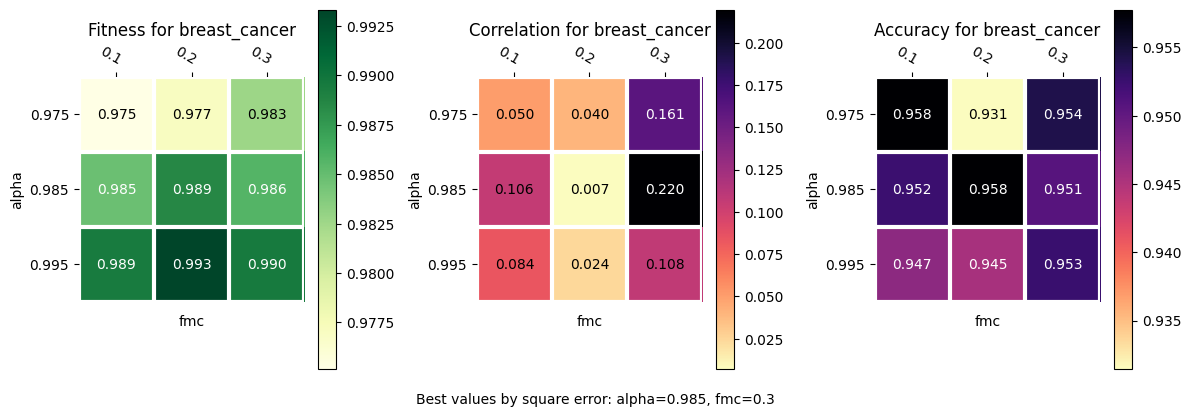

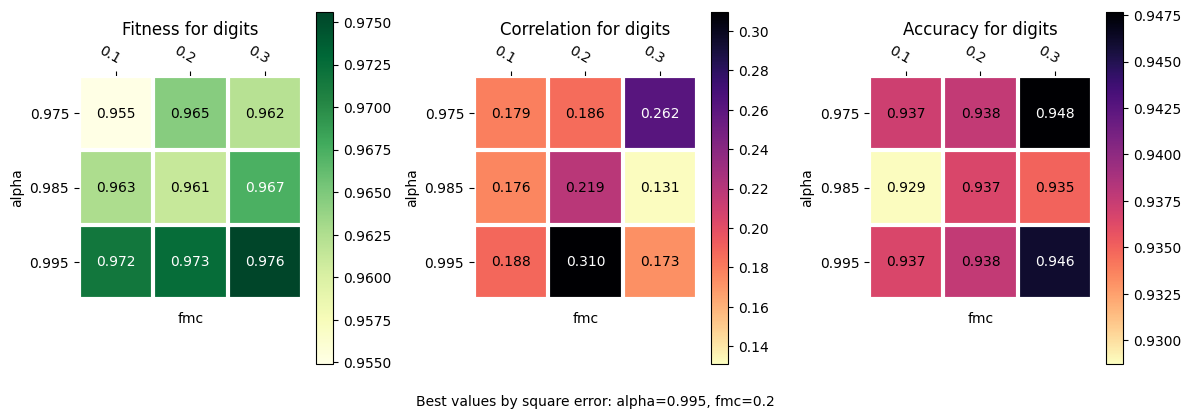

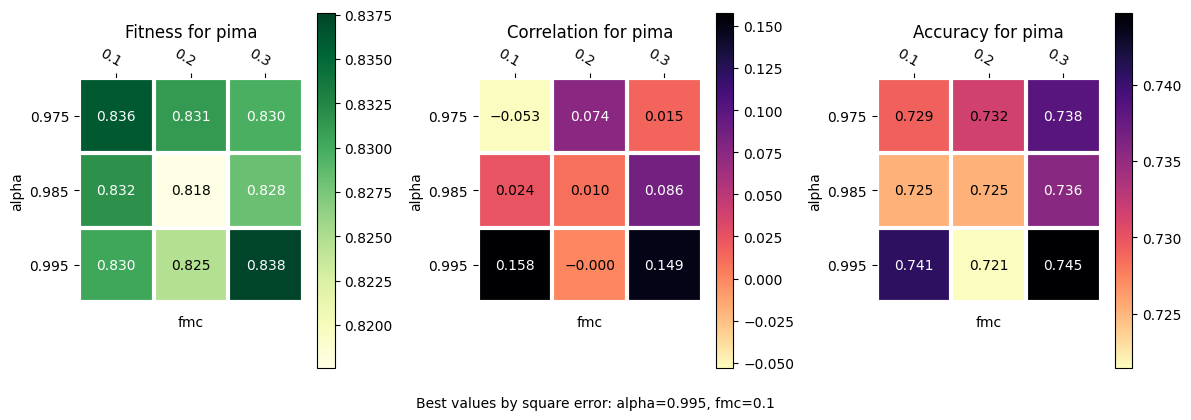

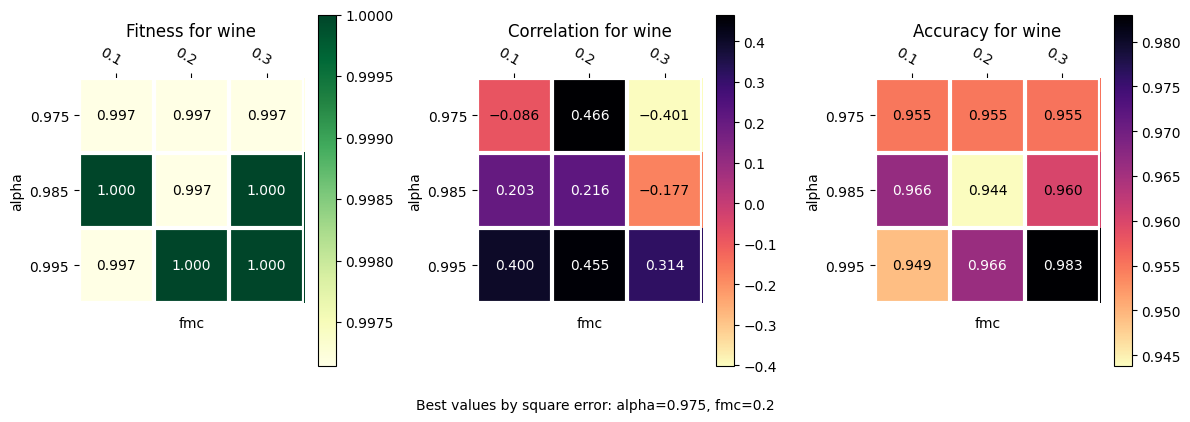

In [10]:
def create_heatmap_for_dataset(df: pd.DataFrame, dataset: str) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    
    tmp = df[df['dataset'] == dataset]
    X = tmp['alpha'].unique()
    Y = tmp['fmc'].unique()
    Z1 = tmp.pivot_table(index='alpha', columns='fmc', values='fitnessMean').values
    Z2 = tmp.pivot_table(index='alpha', columns='fmc', values='correlationMean').values
    Z3 = tmp.pivot_table(index='alpha', columns='fmc', values='accuracyMean').values
    
    ax[0].set_title(f"Fitness for {dataset}")
    ax[0].set_xlabel("fmc")
    ax[0].set_ylabel("alpha")
    im, cbar = heatmap(Z1, X, Y, ax=ax[0], cmap="YlGn", cbarlabel="")
    texts = annotate_heatmap(im, valfmt="{x:.3f}")

    ax[1].set_title(f"Correlation for {dataset}")
    ax[1].set_xlabel("fmc")
    ax[1].set_ylabel("alpha")
    im, cbar = heatmap(Z2, X, Y, ax=ax[1], cmap="magma_r", cbarlabel="")
    texts = annotate_heatmap(im, valfmt="{x:.3f}")
    
    ax[2].set_title(f"Accuracy for {dataset}")
    ax[2].set_xlabel("fmc")
    ax[2].set_ylabel("alpha")
    im, cbar = heatmap(Z3, X, Y, ax=ax[2], cmap="magma_r", cbarlabel="")
    texts = annotate_heatmap(im, valfmt="{x:.3f}")
    
    
    
    fig.tight_layout()
    best_alpha, best_fmc = get_alpha_fmc_for_min_error(df, dataset)

    plt.figtext(0.5, -0.05, f"Best values by square error: alpha={best_alpha}, fmc={best_fmc}", 
                wrap=False, horizontalalignment='center', fontsize=10)
    plt.show()
    

datasets = df['dataset'].unique()    
for dataset in datasets:
    create_heatmap_for_dataset(df, dataset)

# RESULT COMPARISON PLOTS  

In [11]:
def create_comparison_plot(df: pd.DataFrame) -> None:
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))
    
    X = df['nTrees'].unique()
    Y1, Y1_std = df['dtAccuracy'], df['dtAccuracyStd']    
    Y2, Y2_std = df['baggingAccuracy'], df['baggingAccuracyStd'] 
    Y3, Y3_std = df['baggingSAAccuracy'], df['baggingSAAccuracyStd'] 
    
    dataset_name = df['dataset'].values[0]
    
    ax[0].plot(X, Y1, marker='o', label='Decision Tree')
    ax[0].fill_between(X, Y1 - Y1_std, Y1 + Y1_std, alpha=0.2)
    ax[0].plot(X, Y2, marker='o', label='Bagging')
    ax[0].fill_between(X, Y2 - Y2_std, Y2 + Y2_std, alpha=0.2)
    ax[0].plot(X, Y3, marker='o', label='BaggingSA')
    ax[0].fill_between(X, Y3 - Y3_std, Y3 + Y3_std, alpha=0.2)
    
    ax[0].set_title(f"Accuracy per trees amount for dataset: {dataset_name}")
    ax[0].set_xlabel('Number of Trees')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[0].set_xticks(X)
    ax[0].grid()
    
    fig.tight_layout()
    plt.show()
    
    

In [12]:


files = glob.glob('./../res/accuracy_comparison_*.csv')
dfs = [pd.read_csv(f) for f in files]

for df in dfs:
    df_aggregated = df.groupby(['nTrees']).agg(
        dataset=('dataset', 'first'),
        nTrees=('nTrees', 'first'),
        
        dtAccuracy=('dtAccuracy', 'mean'),
        dtAccuracyStd=('dtAccuracy', 'std'),
        baggingAccuracy=('baggingAccuracy', 'mean'),
        baggingAccuracyStd=('baggingAccuracy', 'std'),
        rfAccuracy=('rfAccuracy', 'mean'),
        rfAccuracyStd=('rfAccuracy', 'std'),
        baggingSAAccuracy=('baggingSAAccuracy', 'mean'),
        baggingSAAccuracyStd=('baggingSAAccuracy', 'std'),
        
        dtCorrectPred=('dtCorrectPred', 'mean'),
        dtCorrectPredStd=('dtCorrectPred', 'std'),
        baggingCorrectPred=('baggingCorrectPred', 'mean'),
        baggingCorrectPredStd=('baggingCorrectPred', 'std'),
        rfCorrectPred=('rfCorrectPred', 'mean'),
        rfCorrectPredStd=('rfCorrectPred', 'std'),
        baggingSACorrectPred=('baggingSACorrectPred', 'mean'),
        baggingSACorrectPredStd=('baggingSACorrectPred', 'std'),
        
        dtWrongPred=('dtWrongPred', 'mean'),
        dtWrongPredStd=('dtWrongPred', 'std'),
        baggingWrongPred=('baggingWrongPred', 'mean'),
        baggingWrongPredStd=('baggingWrongPred', 'std'),
        rfWrongPred=('rfWrongPred', 'mean'),
        rfWrongPredStd=('rfWrongPred', 'std'),
        baggingSAWrongPred=('baggingSAWrongPred', 'mean'),
        baggingSAWrongPredStd=('baggingSAWrongPred', 'std')
    ).reset_index(drop=True).dropna()
    
    create_comparison_plot(df_aggregated)
    
    

KeyError: "Column(s) ['baggingAccuracy', 'baggingCorrectPred', 'baggingSAAccuracy', 'baggingSACorrectPred', 'baggingSAWrongPred', 'baggingWrongPred', 'dataset', 'dtAccuracy', 'dtCorrectPred', 'dtWrongPred', 'rfAccuracy', 'rfCorrectPred', 'rfWrongPred'] do not exist"